# Analyse der generierten Bilder

## Analyse der Inbalance hinsichtlich Autos in SDXL:

In [10]:
import os
from PIL import Image
import torch
import random
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel
from diffusers import DiffusionPipeline

Initialisierung der Modelle:

In [2]:
# Initialisiere CLIP und Diffusion-Modell
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Vorbereitung der Bilder auf eine Einheitliche Größe:

In [3]:
def resize_and_crop(image, target_size=(512, 512)):
    width, height = image.size
    # kleineren Wert ermitteln, um das Bild nicht zu verzerren aber auch gleichzeitig so wenig wie möglich an Info zu verlieren 
    new_size = min(width, height)
    
    left = (width - new_size) / 2
    top = (height - new_size) / 2
    right = (width + new_size) / 2
    bottom = (height + new_size) / 2
    
    # Bild croppen und resizen 
    img_cropped = image.crop((left, top, right, bottom))
    img_resized = img_cropped.resize(target_size, Image.LANCZOS)
    
    return img_resized

Implementierung der Funktion, um Klassifizierungen des CLIP-Modells zu zählen:

In [4]:
def count_labels(source_dir):
    # Definiere Prompts für die Bildbeschreibung
    prompts = [
        "new car",
        "old car",
    ]
    
    oldcounter = 0
    newcounter = 0
    
    # Durchlaufe alle Dateien im Quellordner
    for filename in os.listdir(source_dir):
        file_path = os.path.join(source_dir, filename)
        
        if filename.lower().endswith(('.jpg')):
            init_image = Image.open(file_path)
            init_image = resize_and_crop(init_image)
    
            # Verwende CLIP, um einen beschreibenden Prompt für das Bild zu generieren
            inputs = clip_processor(text=prompts, images=init_image, return_tensors="pt")
            outputs = clip_model(**inputs)
            logits_per_image = outputs.logits_per_image
            probs = logits_per_image.softmax(dim=1)
            best_prompt_index = probs.argmax()
            prompt_with_label = prompts[best_prompt_index]
    
            if(prompt_with_label == "old car"):
                oldcounter = oldcounter + 1
            else:
                newcounter = newcounter + 1
    return [oldcounter, newcounter]    

Quellordner

In [5]:
source_dir1 = '../images/car/fake_ImgToImg_without_CLIP/'
source_dir2 = '../images/car/preprocessed_512x/train/fake/'

Ausgabe der Ergebnisse: 

In [6]:
old_new_counts = count_labels(source_dir2)
print("old cars: " + str(old_new_counts[0]))
print("new cars: " + str(old_new_counts[1]))

old cars: 808
new cars: 1435


In [7]:
old_new_counts = count_labels(source_dir1)
print("old cars: " + str(old_new_counts[0]))
print("new cars: " + str(old_new_counts[1]))

old cars: 43
new cars: 0


## Beispiele der generierten Bilder ohne dem CLIP-Modell:

Funktion für das Laden der Bilder:

In [11]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(('.jpg')):
            img_path = os.path.join(folder, filename)
            images.append(img_path)
    return images


Funktion um zufällig Bilder anzuzeigen:

In [12]:
def show_random_images(images, n=40):
    if len(images) < n:
        print(f"Es sind nur {len(images)} Bilder im Verzeichnis vorhanden.")
        n = len(images)
    
    selected_images = random.sample(images, n)
    cols = 8
    rows = (n + cols - 1) // cols  # Aufrunden der Anzahl der Zeilen
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    for ax, img_path in zip(axes.flat, selected_images):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(os.path.basename(img_path), fontsize=8)
    
    for ax in axes.flat[len(selected_images):]:
        ax.axis('off')  # Deaktivieren der nicht verwendeten Subplots
    
    plt.tight_layout()
    plt.show()

Ausgabe der generierten Bilder ohne dem CLIP-Modell:

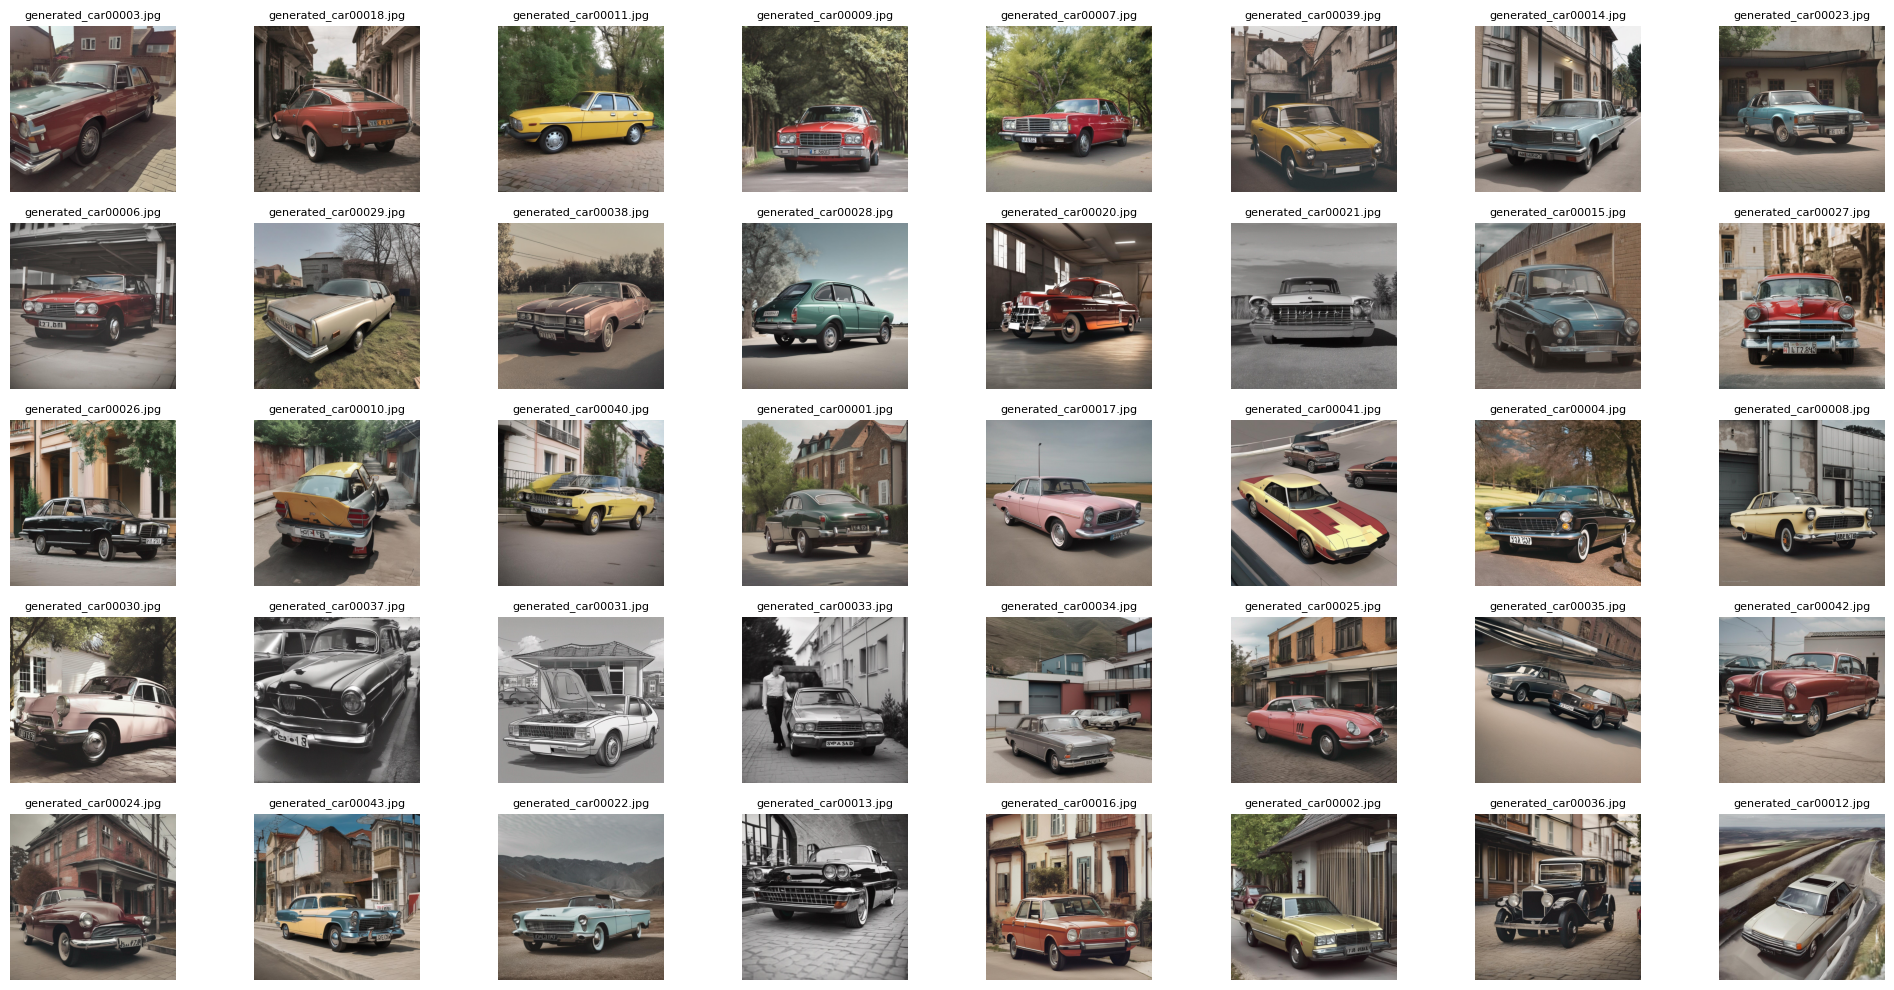

In [13]:
# Bilderverzeichnis
image_folder = "../images/car/fake_ImgToImg_without_CLIP/"

# Bilder laden
image_paths = load_images_from_folder(image_folder)

# Überprüfen, ob Bilder vorhanden sind
if image_paths:
    # Zufällige Bilder anzeigen
    show_random_images(image_paths, 40)

Ausgabe der generierten Bilder mit dem CLIP-Modell:

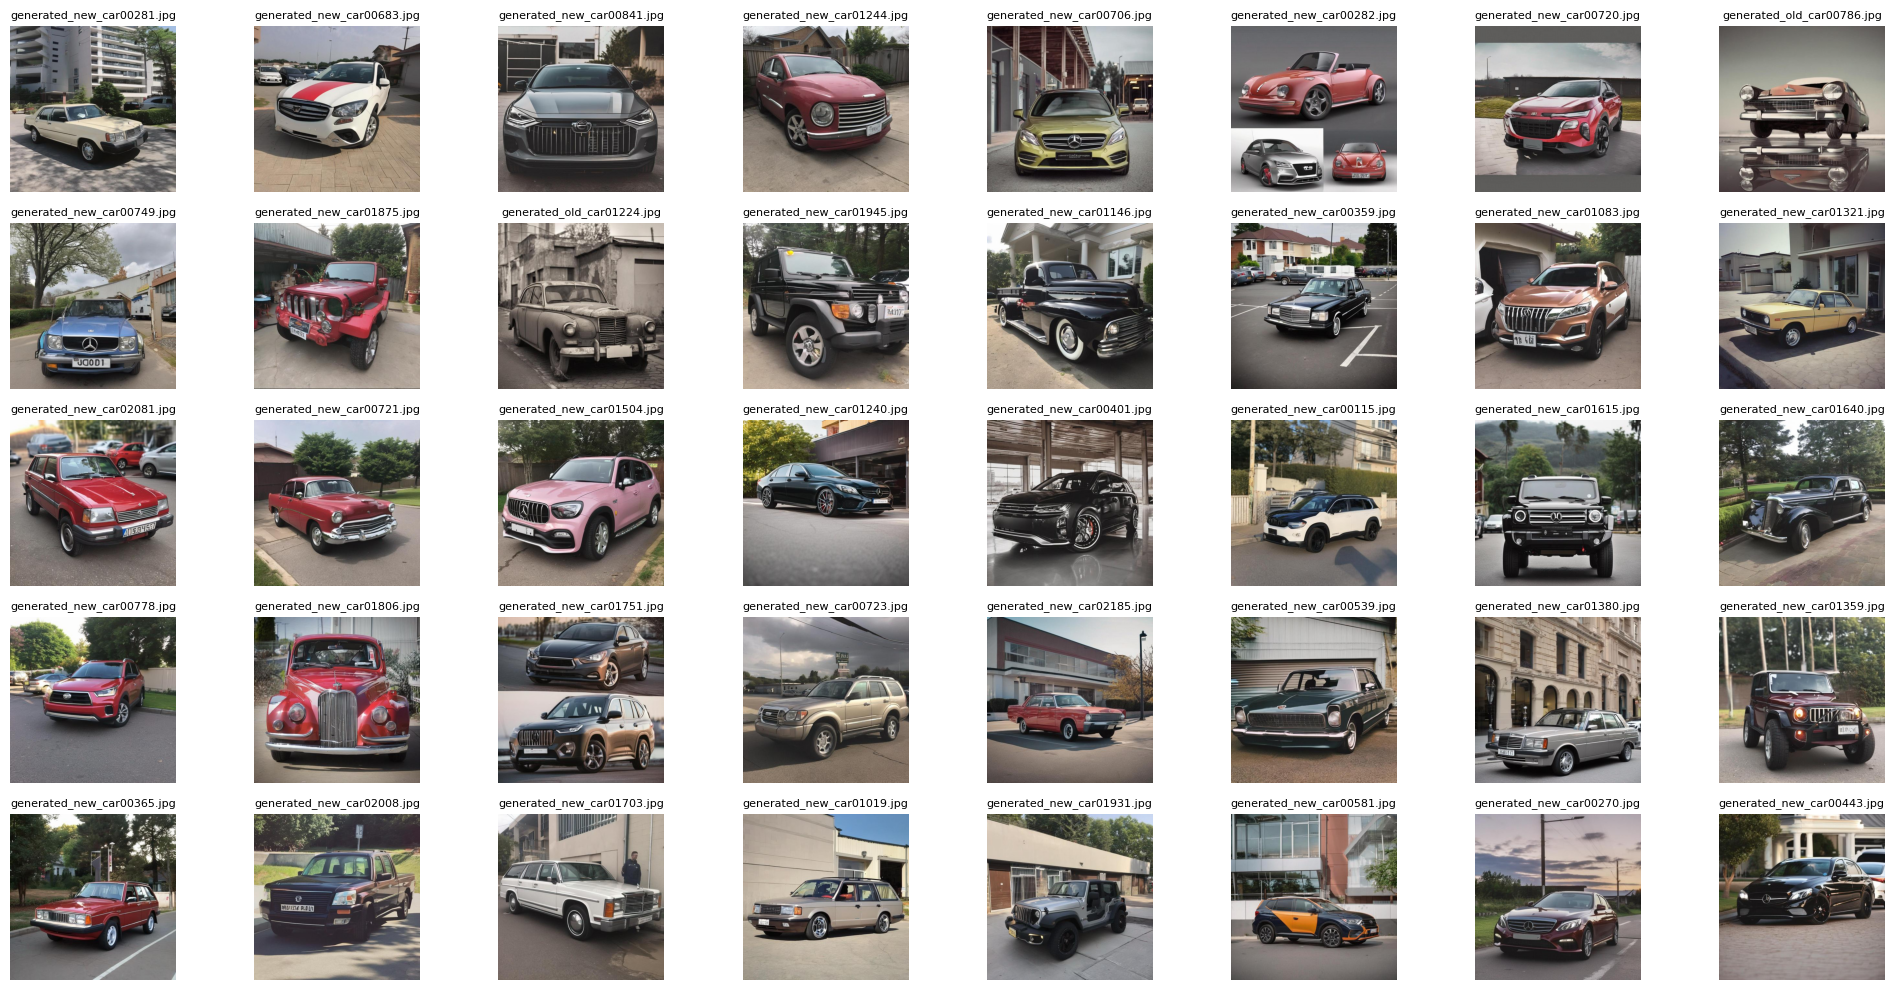

In [14]:
# Bilderverzeichnis
image_folder = "../images/car/preprocessed_512x/train/fake"

# Bilder laden
image_paths = load_images_from_folder(image_folder)

# Überprüfen, ob Bilder vorhanden sind
if image_paths:
    # Zufällige Bilder anzeigen
    show_random_images(image_paths, 40)